## Introducción a Sklearn 🧠 (Extensión Skorch)

Este cuaderno explica cómo definir y entrenar una red neuronal simple con PyTorch y usarla a través de skorch con SciKit-Learn.


**Nota**: Si está ejecutando esto en [un cuaderno Colab](https://colab.research.google.com/github/AcecomFCUNI/Topicos-IA/blob/master/ML-para-Data-Science/Notebooks/Clase1-extension.ipynb), le recomendamos habilite una GPU gratuita yendo a:

> **Runtime**   →   **Cambiar el tipo de runtime**   →   **Acerlación por hardware: GPU**

Si está ejecutando en colab, debe instalar las dependencias y descargar el conjunto de datos ejecutando la siguiente celda:


In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [ ]:
!pip install scikit-learn==0.20.* skorch

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Cargando datos
Usando SciKit-Learns ```fetch_openml``` para cargar datos MNIST.

In [ ]:
mnist = fetch_openml('mnist_784', cache=False)

In [ ]:
mnist.data.shape

(70000, 784)

## Pre-procesamiento de los datos

Cada imagen del conjunto de datos MNIST está codificada en un vector de 784 dimensiones, que representa una imagen de 28 x 28 píxeles. Cada píxel tiene un valor entre 0 y 255, que corresponde al valor de gris de un píxel. <br />
El método anterior ```featch_mldata``` para cargar MNIST devuelve ``` data``` y ```target``` como ``` uint8``` que convertimos a ```float32``` y ```int64``` respectivamente.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

Para evitar grandes pesos que se ocupan de los valores de píxeles entre [0, 255], escalamos "X" hacia abajo. Un rango de uso común es [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Nota: los datos no están normalizados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Imprimiendo una selección de imágenes de entrenamiento y sus etiquetas

In [ ]:
def plot_example(X, y):
    """Ploteamos las primeras 5 imágenes y sus etiquetas en una fila.."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

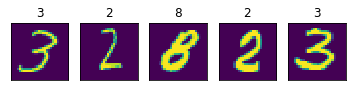

In [ ]:
plot_example(X_train, y_train)

## Construyendo una red neuronal con PyTorch
Es una red neuronal simple y completamente conectada con una capa oculta. La capa de entrada tiene 784 dimensiones (28x28), la capa oculta tiene 98 (= 784/8) unidades y la capa de salida 10 neuronas, que representan los dígitos 0 - 9.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

Una red neuronal en el marco de PyTorch.

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

*Skorch* permite usar las redes de PyTorch en la configuración de SciKit-Learn:

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8299       0.8893        0.4037  0.8951
      2        0.4331       0.9113        0.3075  0.7862
      3        0.3619       0.9240        0.2614  0.8314
      4        0.3237       0.9305        0.2379  0.7739
      5        0.2914       0.9371        0.2173  0.7721
      6        0.2739       0.9413        0.1979  0.7949
      7        0.2569       0.9449        0.1859  0.7691
      8        0.2420       0.9461        0.1813  0.7871
      9        0.2337       0.9496        0.1708  0.7730
     10        0.2195       0.9532        0.1604  0.7992
     11        0.2151       0.9547        0.1514  0.7955
     12        0.2065       0.9560        0.1476  0.7734
     13        0.2015       0.9563        0.1455  0.8316
     14        0.1943       0.9587        0.1389  0.7913
     15        0.1883       0.9578        0.1381  0.8092
     16        0.1848       0.9

## Predicción

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9627428571428571

Un accuracy de aproximadamente el 96% para una red con una sola capa oculta no es tan mala.

Echemos un vistazo a algunas predicciones que salieron mal:

In [ ]:
error_mask = y_pred != y_test

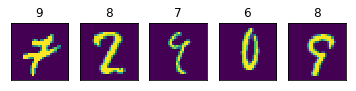

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])